# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/wbr/analysis


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/bjet_binned/'
selections = [
              'emu', 
              'mumu',  'mutau', 'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )
#p_labels = [r'$\beta_{e}$', r'$\beta_{\mu}$', r'$\beta_{\tau}$', r'$\beta_{h}$',
#            r'$\sf L_{int}$', 
#            r'$\sigma_{t\bar{t}}$',  r'$\sigma_{z}$',  r'$\sigma_{w}$', r'$\sf k_{fakes}$', 
#            r'$\sf \epsilon_{e}$', r'$\sf \epsilon_{\mu}$', r'$\sf \epsilon_{\tau}$']

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for b, bdata in sdata.items():
        if b == 0 and selection in ['e4j', 'mu4j']: 
            continue
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][b] = np.zeros(bdata['bins'].size - 1)
        for sig in ['ttbar', 't', 'wjets']: # figure out wjets: needs separate decay map from tt/tW
            signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in templates[sig].items())
            if sig == 'wjets':
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=True)
            else:
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False)
            toy_data[selection][b] += signal
        
        # background component
        for bg in ['zjets', 'diboson', 'fakes']:
            if bg == 'fakes': #and selection not in ['mu4j', 'e4j', 'mutau', 'etau']:
                continue

            toy_data[selection][b] += templates[bg]['val']

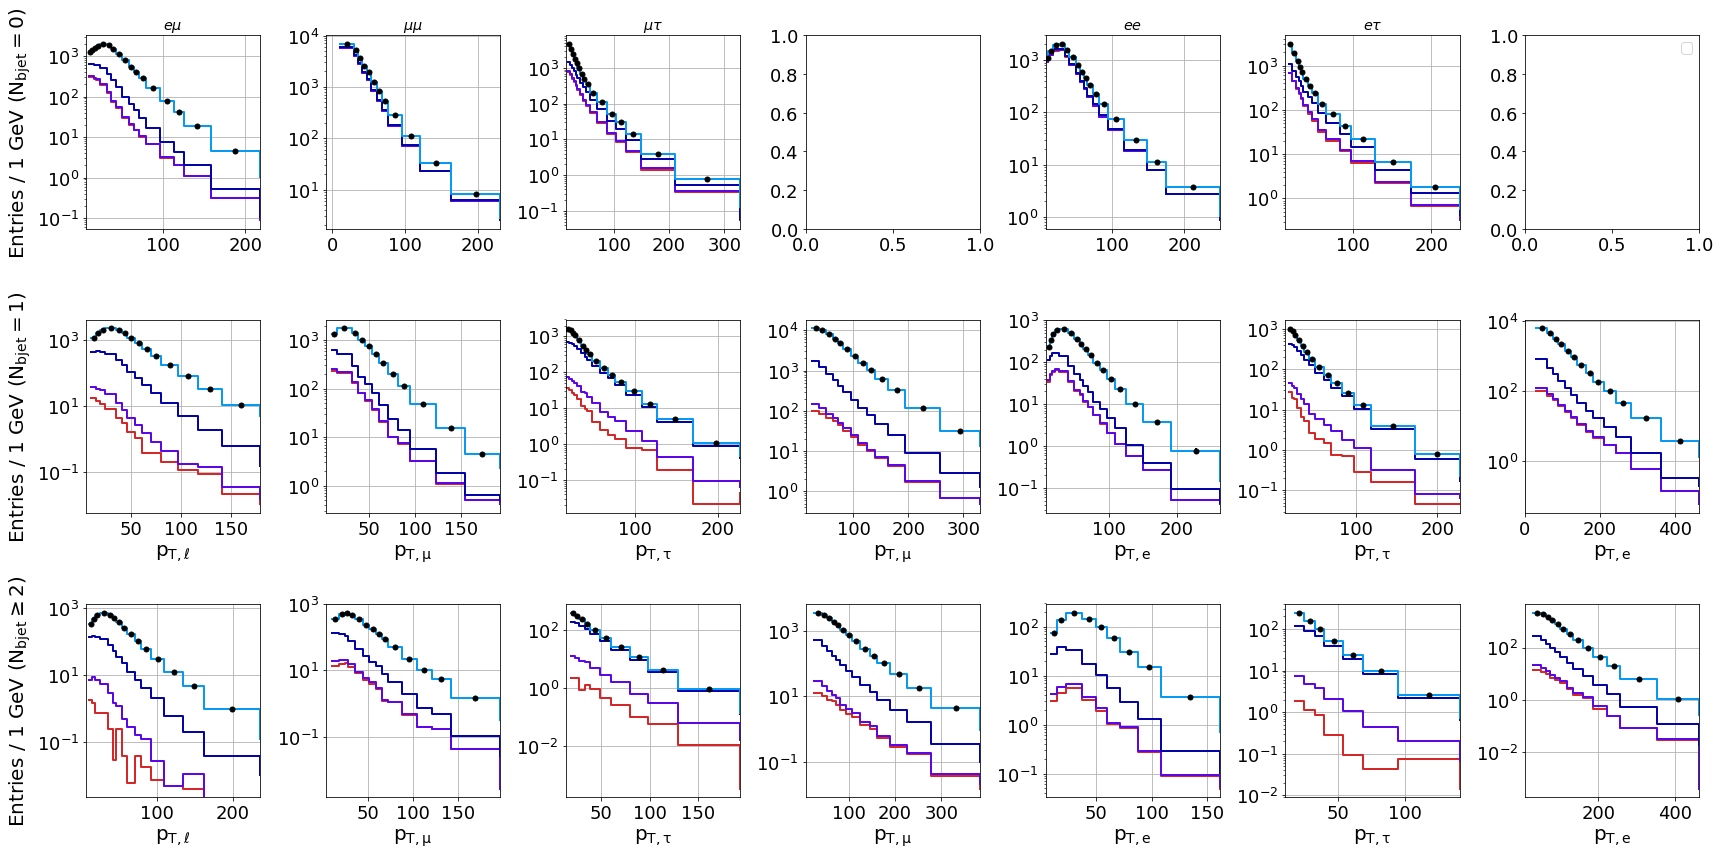

In [ ]:
# visualize toy data
fig, axes = plt.subplots(3, 7, figsize=(24, 12), facecolor='white')
for i, selection in enumerate(selections):
    sdata = fit_data.get_selection_data(selection)
    for j, (b, bdata) in enumerate(sdata.items()):
        if b == 0: 
            axes[b, i].set_title(plot_labels[selection][1])
            
            if selection in ['e4j', 'mu4j']: 
                #axes[b, i].axis('off')
                continue # and selection not in ['etau', 'mutau']: continue
            
        # get and plot the data 
        templates = bdata['templates']
        bins = bdata['bins'][:-1]
        dx = (bins[1:] - bins[:-1])
        dx = np.append(dx, dx[-1]) 
        x  = bins + dx/2            

        ax = axes[b, i]
        data = toy_data[selection][b]
        ax.errorbar(x, data/dx, np.sqrt(data)/dx, fmt='ko', linewidth=2., markersize=5)
        
        # background component
        h_bg = np.zeros(data.shape)
        for bg_label in ['zjets', 'diboson', 'fakes']:
            if bg_label == 'fakes':# and selection not in ['mu4j', 'mutau', 'etau']:
                continue
            h_bg += templates[bg_label]['val']
        
        ## signal component
        h_twotau  = np.zeros(h_bg.shape)
        h_onetau  = np.zeros(h_bg.shape)
        h_nominal = np.zeros(h_bg.shape)
        for sig in ['ttbar', 't', 'wjets']:
            signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in templates[sig].items()) 

            if sig == 'wjets':
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=np.array([0, 0, 1, 1, 1, 0]), single_w=True)
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template, single_w=True)
            else:
                h_twotau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_twotau'])
                h_onetau  += fh.signal_mixture_model(beta_init, br_tau, signal_template, mask=fit_data._decay_map['sig_onetau'])
                h_nominal += fh.signal_mixture_model(beta_init, br_tau, signal_template)
                
        h_nominal += h_bg
        h_twotau += h_bg
        h_onetau += h_twotau
        
        ax.plot(bins, h_bg/dx, drawstyle='steps-post', c='C3', linestyle='-', linewidth=2.)
        ax.plot(bins, h_twotau/dx, drawstyle='steps-post', c='xkcd:blue violet', linestyle='-', linewidth=2.)
        ax.plot(bins, h_onetau/dx, drawstyle='steps-post', c='xkcd:royal blue', linestyle='-', linewidth=2.)
        ax.plot(bins, h_nominal/dx, drawstyle='steps-post', c='xkcd:azure', linestyle='-', linewidth=2.)
        
        xmin, xmax = bins[0]-dx[0], bins[-2]+dx[-2]
        ax.set_xlim(xmin, xmax)
        #ax.set_ylim(0.01, 10.*np.max(h_nominal[0]/dx))
        ax.set_yscale('log')
            
        if b == 0:
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 0$)')
        elif b == 1:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} = 1$)')
        elif b == 2:
            ax.set_xlabel(plot_labels[selection][0])
            if i == 0:
                ax.set_ylabel(r'Entries / 1 GeV ($\sf N_{b jet} \geq 2$)')
        ax.grid()
    
    axes[0][-1].legend(['bg', r'2 $\tau$', r'1 $\tau$', r'0 $\tau$', 'toy data'], fontsize=14)
    
plt.tight_layout()
plt.savefig('plots/toy_mc_example.pdf')
plt.show()

In [ ]:
# nominal case
cost_type = 'poisson'
p_init = fit_data.get_params_init()
fobj = partial(fit_data.objective, data=toy_data, cost_type=cost_type)
stderr, corr = fh.calculate_covariance(fobj, p_init)

In [ ]:
# plot errors
params = fit_data._parameters
p_labels = params.index.values
p_init = params.val_init.values

pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', len(p_labels))
pd.set_option('display.max_rows', len(p_labels))

#print(result.x)
#print(cov[0])
pct_err = pd.DataFrame(np.array([p_init, 100*params.err_init, 100*stderr, stderr/params.err_init]).T, 
                       index=p_labels, 
                       columns=['p_init', 'err_init', 'stderr (%)', 'constraint']
                      )
pct_err

In [ ]:
df_corr = pd.DataFrame(corr, columns=p_labels, index=p_labels)
df_corr.to_latex('data/cov_table_full.tex')
df_corr.to_csv('data/cov_table_full.csv')

import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16, 12))
sns.heatmap(df_corr, cmap='Spectral', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.show()

### Estimating individual contributions

If we make the assumption that the uncertainties sum in quadrature (which they should really given all of the correlations), we can write the total uncertainty as,

$$
\sigma_{total}^{2} = \sigma_{stat}^{2} + \sum_{i}\sigma_{i,syst}^{2}
$$

From this we can write evaluate the contribution from a single systematic source as,

$$
\sigma_{i,syst}^{2} = \sigma_{total}^{2} - \sigma_{stat}^{2} - \sum_{j\neq i}\sigma_{j,syst}^{2}
$$
